rs8085824 is on chrom 18:46449111 T>C, we use the cross validation fold with chrom 18 in test set (split 7). 

Note: the MPRA used the reverse complement sequence, so the SNP is 

In [66]:
snp='rs8085824'
split=6
snp_chrom="chr18"
snp_pos=46449111

In [67]:
#load dragonn tutorial utilities 
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


In [68]:
from keras.models import load_model

In [69]:
from dragonn.generators import  revcomp

In [70]:
import pysam
# SNP is at position 101 in the 200 bp MPRA construct 
def get_inputs(chrom,snp_pos,flank=100,ref="/mnt/data/annotations/by_release/hg19.GRCh37/hg19.genome.fa",use_revcomp=False):
    ref=pysam.FastaFile(ref)
    ltrdict = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0],'A':[1,0,0,0],'C':[0,1,0,0],'G':[0,0,1,0],'T':[0,0,0,1],'N':[0,0,0,0]}
    snp_pos=snp_pos-1 #convert to 0-indexing
    left_flank=ref.fetch(chrom,snp_pos-flank,snp_pos)
    print(len(left_flank))
    right_flank=ref.fetch(chrom,snp_pos+1,snp_pos+flank)
    print(len(right_flank))
    encoded=dict() 
    seqs=dict()
    for base in ['A','C','G','T']: 
        curseq=left_flank+base+right_flank
        if use_revcomp==True: 
            curseq=revcomp(curseq)
        seqs[base]=curseq
        encoded[base]=np.expand_dims(np.expand_dims(np.array([ltrdict.get(x,[0,0,0,0]) for x in curseq]),0),0)
    return encoded,seqs

In [71]:
##load the model 
from concise.metrics import tpr, tnr, fpr, fnr, precision, f1

custom_objects={"sensitivity":tpr,
                "specificity":tnr,
                "fpr":fpr,
                "fnr":fnr,
                "precision":precision,
                "f1":f1}

model=load_model("v4/gecco.classification.SummitWithin200bpCenter."+str(split),custom_objects=custom_objects)

In [72]:
#get deepLIFT function 
from deeplift.conversion import kerasapi_conversion as kc
import keras.backend as K 
deeplift_model = kc.convert_model_from_saved_files("v4/gecco.classification.SummitWithin200bpCenter."+str(split),verbose=False)

In [73]:
#get the deeplift score with respect to the logit                                                                                                                    
score_func = deeplift_model.get_target_contribs_func(
find_scores_layer_idx=0,
    target_layer_idx=-2)


In [74]:
import numpy as np 
input_references = [np.array([0.3, 0.2, 0.2, 0.3])[None, None, None, :]]

 We have the fasta sequence from "CC_pilot-MPRA.fa"

>rs8085824-bash
GGGAGGGATGAGGGCgGAGCAGGGCGCCCTGCAGGCTCCAGATGCTTCTGTGGAAGGAGGGGAGAGAGGGGGCACCCCTGGGGATGGGGGTGCCGGCAGgGAAGGGGAGAAGGGGGACGCATCTATTTGAGACACATAATCTTCTGTCTGGGCTGGAGGAAGCTTTGTTAAGGTAGCCcGGGTTAATACCGGTCTGCATG


In [75]:
mpra_seq="GGGAGGGATGAGGGCgGAGCAGGGCGCCCTGCAGGCTCCAGATGCTTCTGTGGAAGGAGGGGAGAGAGGGGGCACCCCTGGGGATGGGGGTGCCGGCAGgGAAGGGGAGAAGGGGGACGCATCTATTTGAGACACATAATCTTCTGTCTGGGCTGGAGGAAGCTTTGTTAAGGTAGCCcGGGTTAATACCGGTCTGCATG"

In [76]:
mpra_seq[101] #reference allele "a" at position 101 in the sequence , 100 bp left flank, 99 bp right flank 

'A'

In [77]:
## extract the 1kb region centered at the SNP 
X,seqs=get_inputs(snp_chrom,snp_pos,use_revcomp=False)


100
99


In [79]:
#verify we have extracted the same sequence that was used in the MPRA 
revcomp(seqs['C'].upper())==mpra_seq.upper()

True

In [108]:
#Now, pad to 1000 bp by using a 500 bp flank 
X,seqs=get_inputs(snp_chrom,snp_pos,flank=500,use_revcomp=True)

500
499


In [109]:
tasks=["Healthy",'Tumor',"SW480","HCT116","COLO205"]
print(tasks)
# get the model predictions 
for base in ['A','C','G','T']: 
    print(base+":"+str(model.predict(X[base])))

['Healthy', 'Tumor', 'SW480', 'HCT116', 'COLO205']
A:[[0.11958685 0.490915   0.01396153 0.00387551 0.07118214]]
C:[[0.10711172 0.5017104  0.0009361  0.00070156 0.06020794]]
G:[[0.119551   0.49056852 0.00523089 0.00196638 0.0653767 ]]
T:[[0.10317916 0.48494512 0.00183333 0.00112391 0.06074911]]


In [110]:
## pretty print
print('\t'+'\t'.join(tasks))
for base in ['A','C','G','T']:
    print(base+'\t'+'\t'.join([str(round(i,3)) for i in model.predict(X[base])[0]]))

	Healthy	Tumor	SW480	HCT116	COLO205
A	0.12	0.491	0.014	0.004	0.071
C	0.107	0.502	0.001	0.001	0.06
G	0.12	0.491	0.005	0.002	0.065
T	0.103	0.485	0.002	0.001	0.061


In [112]:
## Healthy	Tumor	SW480	HCT116	COLO205 (task order)
dl_scores_A=dict() 
for t_index in range(5):
    dl_scores_A[tasks[t_index]]=score_func(
                        task_idx=t_index,
                        input_data_list=[X['A']],
                        batch_size=1,
                        progress_update=None,
                        input_references_list=input_references)

In [113]:
## Healthy	Tumor	SW480	HCT116	COLO205 (task order)
dl_scores_C=dict() 
for t_index in range(5):
    dl_scores_C[tasks[t_index]]=score_func(
                        task_idx=t_index,
                        input_data_list=[X['C']],
                        batch_size=1,
                        progress_update=None,
                        input_references_list=input_references)

In [114]:
## Healthy	Tumor	SW480	HCT116	COLO205 (task order)
dl_scores_G=dict() 
for t_index in range(5):
    dl_scores_G[tasks[t_index]]=score_func(
                        task_idx=t_index,
                        input_data_list=[X['G']],
                        batch_size=1,
                        progress_update=None,
                        input_references_list=input_references)

In [115]:
## Healthy	Tumor	SW480	HCT116	COLO205 (task order)
dl_scores_T=dict() 
for t_index in range(5):
    dl_scores_T[tasks[t_index]]=score_func(
                        task_idx=t_index,
                        input_data_list=[X['T']],
                        batch_size=1,
                        progress_update=None,
                        input_references_list=input_references)

In [116]:
from dragonn.tutorial_utils import  plot_seq_importance

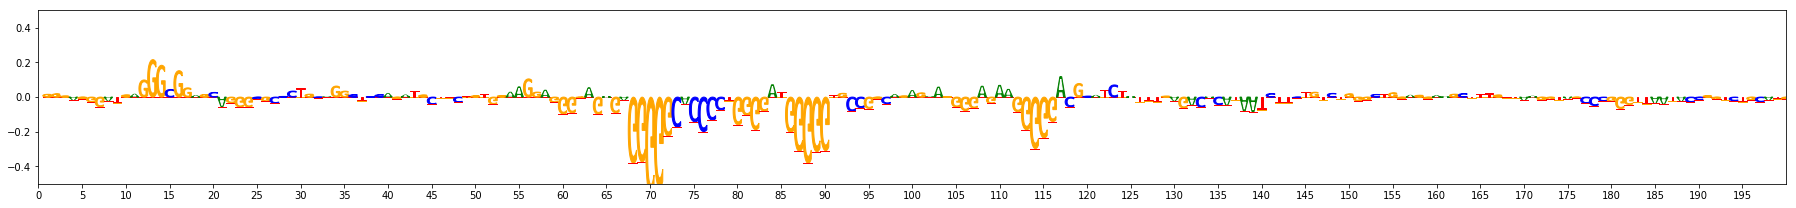

In [117]:
tmp1=dl_scores_T['HCT116'][0].squeeze()[400:600]
tmp2=X['T'].squeeze()[400:600]
plot_seq_importance(tmp1,tmp2,ylim=(-0.5,0.5))

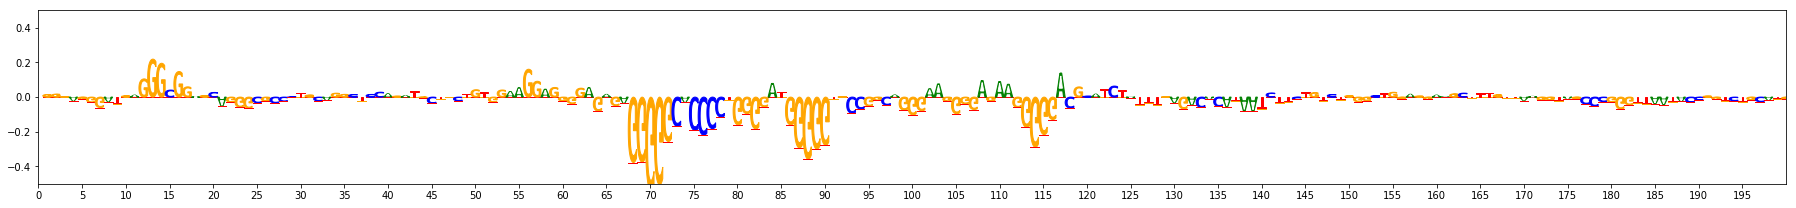

In [118]:
tmp3=dl_scores_C['HCT116'][0].squeeze()[400:600]
tmp4=X['C'].squeeze()[400:600]
plot_seq_importance(tmp3,tmp4,ylim=(-0.5,0.5))

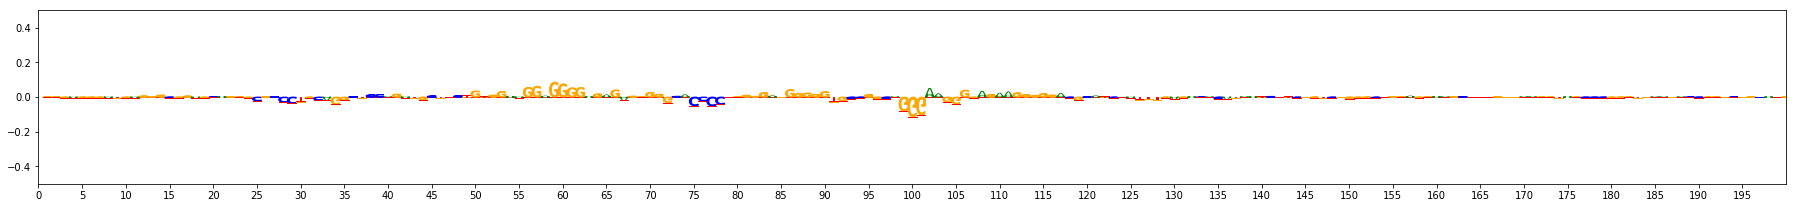

In [119]:
#delta track for the alternate C allele - reference A allele (with C at position 101)
plot_seq_importance(tmp3-tmp1,tmp4,ylim=(-0.5,0.5))

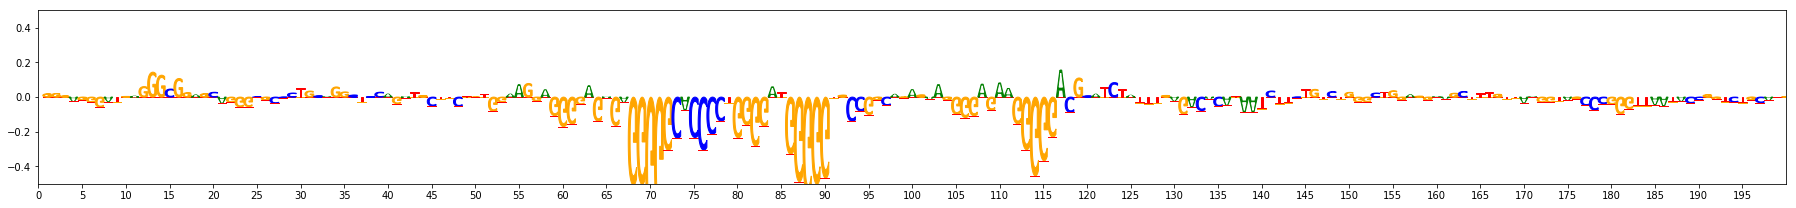

In [120]:
tmp1=dl_scores_T['SW480'][0].squeeze()[400:600]
tmp2=X['T'].squeeze()[400:600]

plot_seq_importance(tmp1,tmp2,ylim=(-0.5,0.5))

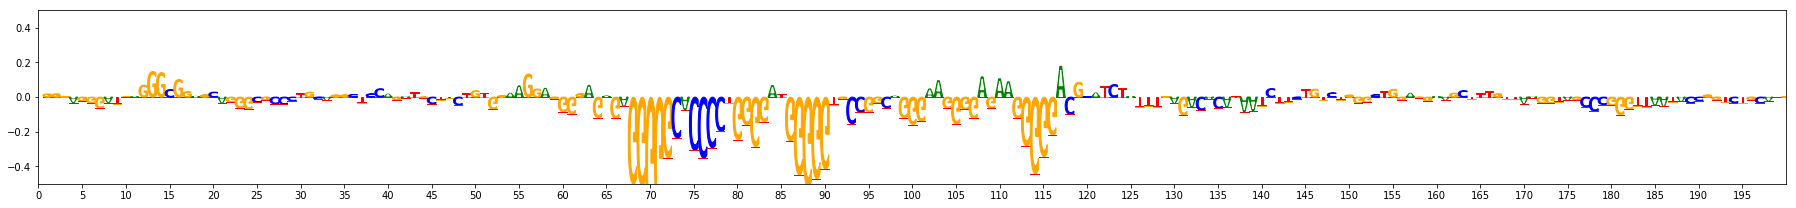

In [121]:
tmp3=dl_scores_C['SW480'][0].squeeze()[400:600]
tmp4=X['C'].squeeze()[400:600]
plot_seq_importance(tmp3,tmp4,ylim=(-0.5,0.5))

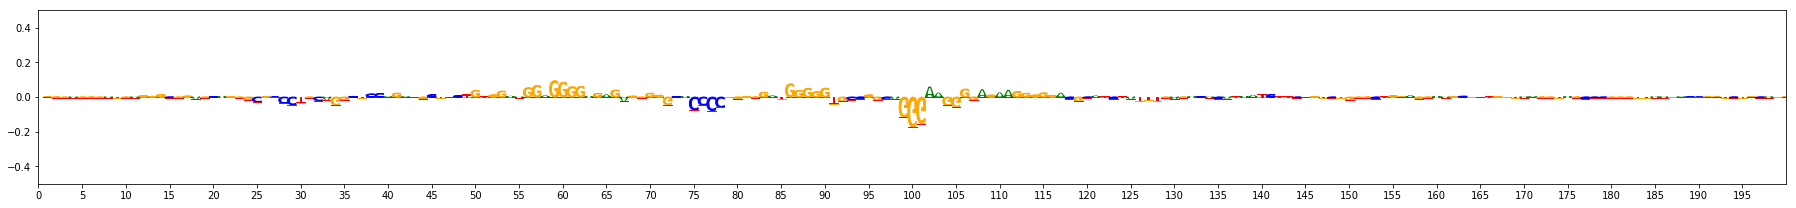

In [122]:
plot_seq_importance(tmp3-tmp1,tmp4,ylim=(-0.5,0.5))

In [123]:
import pandas as pd 
bashed=pd.read_csv("/srv/scratch/annashch/gecco/20190207_Pilot_Data_Freeze_1/CC_Pilot_HCT116_20180208.out",header=0,sep='\t')

In [124]:
bashed

,Row.names,SNP,Project,window,strand,allele,haplotype,bash,Ctrl.Mean,Exp.Mean,log2FoldChange,lfcSE,stat,pvalue,padj
0,(rs6507874:rs6507875:CC-bash_M:g93A;rs6507874:...,rs6507874:rs6507875:CC-bash,bash,NaN,rev,NaN,ref,M:g93A,1106.282775,1041.784418,-0.086092,0.134206,-0.641489,5.212050e-01,7.679299e-01
1,(rs6507874:rs6507875:CC-bash_M:g93T;rs6507874:...,rs6507874:rs6507875:CC-bash,bash,NaN,rev,NaN,ref,M:g93T,927.357086,906.494547,-0.032622,0.138925,-0.234816,8.143516e-01,9.265243e-01
2,(rs6507874:rs6507875:CC-bash;rs6507874:rs65078...,rs6507874:rs6507875:CC-bash,bash,NaN,rev,NaN,ref,ref,10685.015473,10460.241526,-0.030670,0.057713,-0.531427,5.951230e-01,8.162193e-01
3,(rs6507874:rs6507875:CG-bash_M:g107T;rs6507874...,rs6507874:rs6507875:CG-bash,bash,NaN,rev,NaN,ref,M:g107T,1420.272306,1474.466440,0.054679,0.091932,0.594779,5.519912e-01,7.896405e-01
4,(rs6507874:rs6507875:CG-bash;rs6507874:rs65078...,rs6507874:rs6507875:CG-bash,bash,NaN,rev,NaN,ref,ref,6500.313252,6367.043572,-0.029839,0.095733,-0.311688,7.552774e-01,9.010281e-01
5,(rs6507874:rs6507875:TC-bash_M:a107C;rs6507874...,rs6507874:rs6507875:TC-bash,bash,NaN,rev,NaN,ref,M:a107C,1939.838257,1825.183773,-0.088352,0.126818,-0.696685,4.860002e-01,7.437987e-01
6,(rs6507874:rs6507875:TC-bash_M:a107T;rs6507874...,rs6507874:rs6507875:TC-bash,bash,NaN,rev,NaN,ref,M:a107T,2338.063022,2536.685920,0.117590,0.123022,0.955846,3.391500e-01,6.227182e-01
7,(rs6507874:rs6507875:TC-bash_M:g93T;rs6507874:...,rs6507874:rs6507875:TC-bash,bash,NaN,rev,NaN,ref,M:g93T,2137.806400,2508.904606,0.230528,0.104347,2.209241,2.715786e-02,1.155894e-01
8,(rs6507874:rs6507875:TC-bash;rs6507874:rs65078...,rs6507874:rs6507875:TC-bash,bash,NaN,rev,NaN,ref,ref,7171.257311,6757.766057,-0.085713,0.077250,-1.109547,2.671941e-01,5.481396e-01
9,(rs6507874:rs6507875:TG-bash_M:a107C;rs6507874...,rs6507874:rs6507875:TG-bash,bash,NaN,rev,NaN,ref,M:a107C,971.008535,1106.639371,0.188119,0.152052,1.237197,2.160138e-01,4.866579e-01


In [125]:

bashed_snp_subset=dict()
bashed_snp_subset['pos']=[]
bashed_snp_subset['allele']=[]
bashed_snp_subset['lfc']=[]
for index,row in bashed.iterrows(): 
    if str(row['SNP']).startswith(snp) and row['SNP'].endswith('bash'): 
        #this is our target SNP
        bashinfo=row['bash']
        if bashinfo=='ref':
            continue
        bashinfo=bashinfo.split(":")[1]
        ref_allele=bashinfo[0].upper() 
        alt_allele=bashinfo[-1]
        pos=int(bashinfo[1:-1])
        bashed_snp_subset['pos'].append(pos)
        bashed_snp_subset['allele'].append(alt_allele)
        bashed_snp_subset['lfc'].append(row['log2FoldChange'])
        

In [126]:
bashed_snp_subset=pd.DataFrame(bashed_snp_subset)

In [127]:
bashed_snp_subset

,pos,allele,lfc
0,102,C,0.351192
1,102,G,0.290722
2,102,T,0.415925
3,103,C,0.235929
4,103,G,0.279100
5,103,T,0.316509
6,108,C,0.118612
7,108,G,0.591790
8,108,T,0.498892
9,110,C,0.346230


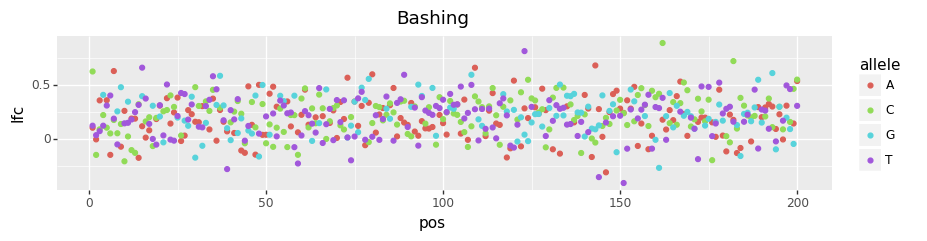

<ggplot: (8728724343521)>

In [128]:
from plotnine import * 
import plotnine
plotnine.options.figure_size = (10,2)

(ggplot(bashed_snp_subset)
 +aes(x="pos",y="lfc",group="allele",color="allele")
 +geom_point()
 +ggtitle("Bashing"))

In [129]:
dl_ref=np.asarray(dl_scores_A['HCT116'][0].squeeze()[400:600])
dl_ref=pd.DataFrame(dl_ref,columns=["A","C","G","T"])
dl_ref['pos']=range(1,201)
dl_ref_melted=pd.melt(dl_ref, id_vars=['pos'])
dl_ref_melted.columns=['pos','allele','deepLIFT']

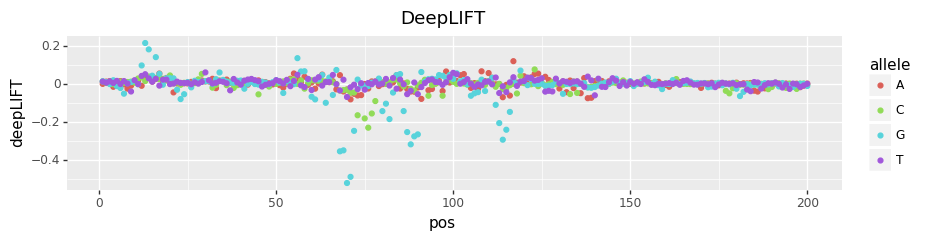

<ggplot: (-9223363308129101424)>

In [130]:
plotnine.options.figure_size = (10,2)

(ggplot(dl_ref_melted)
 +aes(x="pos",y="deepLIFT",group="allele",color="allele")
 +geom_point()
 +ggtitle("DeepLIFT"))

## SW480

In [131]:
import pandas as pd 
bashed=pd.read_csv("/srv/scratch/annashch/gecco/20190207_Pilot_Data_Freeze_1/CC_Pilot_SW480_20180208.out",header=0,sep='\t')

In [132]:

bashed_snp_subset=dict()
bashed_snp_subset['pos']=[]
bashed_snp_subset['allele']=[]
bashed_snp_subset['lfc']=[]
for index,row in bashed.iterrows(): 
    if str(row['SNP']).startswith(snp) and row['SNP'].endswith('bash'): 
        #this is our target SNP
        bashinfo=row['bash']
        if bashinfo=='ref':
            continue
        bashinfo=bashinfo.split(":")[1]
        ref_allele=bashinfo[0].upper() 
        alt_allele=bashinfo[-1]
        pos=int(bashinfo[1:-1])
        bashed_snp_subset['pos'].append(pos)
        bashed_snp_subset['allele'].append(alt_allele)
        bashed_snp_subset['lfc'].append(row['log2FoldChange'])
        

In [133]:
bashed_snp_subset=pd.DataFrame(bashed_snp_subset)

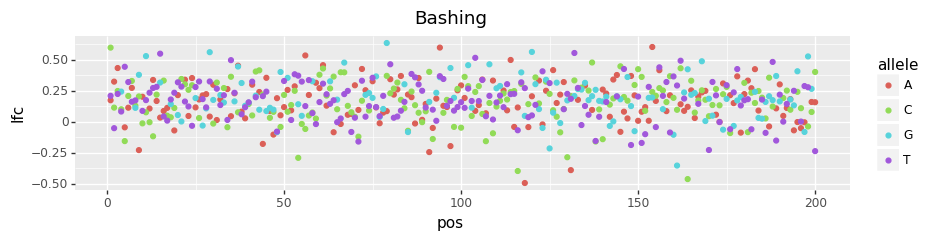

<ggplot: (8728724224758)>

In [134]:
from plotnine import * 
plotnine.options.figure_size = (10,2)

(ggplot(bashed_snp_subset)
 +aes(x="pos",y="lfc",group="allele",color="allele")
 +geom_point()
 +ggtitle("Bashing"))

In [135]:
dl_ref=np.asarray(dl_scores_A['SW480'][0].squeeze()[400:600])
dl_ref=pd.DataFrame(dl_ref,columns=["A","C","G","T"])
dl_ref['pos']=range(1,201)
dl_ref_melted=pd.melt(dl_ref, id_vars=['pos'])
dl_ref_melted.columns=['pos','allele','deepLIFT']

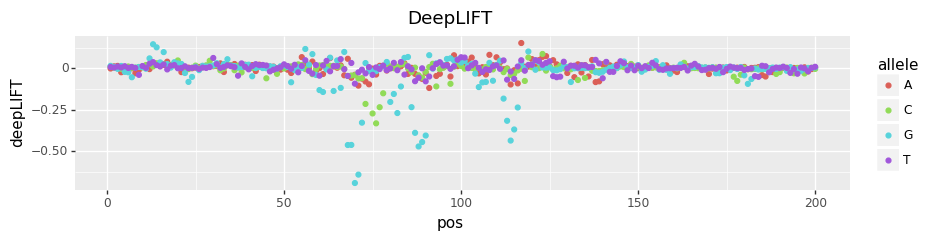

<ggplot: (8728724224667)>

In [136]:
plotnine.options.figure_size = (10,2)

(ggplot(dl_ref_melted)
 +aes(x="pos",y="deepLIFT",group="allele",color="allele")
 +geom_point()
 +ggtitle("DeepLIFT"))